In [2]:
# %matplotlib widget 

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib import cm, animation, rc

from pdb import set_trace

In [3]:
def update_w(w, err, jac, eta = 1, q=0):
    if w.shape[0] == 1:                # 1-d update
        update = jac ** (1 - q) * err
    elif w.shape[0] == 2:              # 2-d update
        U, d, V = svd_2d(jac)
        update = U * (d ** (1 - q)) @ V @ err
    return w - eta * update

def svd_2d(M):   #   SVD of 2x2 matrix M:  U and V are orthogonal, D is diagonal, and A=U*D@V
    U = get_orth_matrix(M @ M.T)
    V = get_orth_matrix(M.T @ M)
    d = np.diag(U.T @ M @ V)
    
    # sign correction
    V = np.sign(d) * V
    d = np.abs(d)    
    return U, d, V.T

def get_orth_matrix(S):
    theta   = 0.5*np.arctan2(S[0,1]+S[1,0], S[0,0]-S[1,1])   
    Cos, Sin = np.cos(theta), np.sin(theta)
    return np.array([[Cos, -Sin], [Sin, Cos]])
    

In [4]:
def run_exp(fnc, w0, qs, etas, iter = 100):
    w_alls = []; l_alls = []; w_mins = []; w_maxs = []
    
    for q, eta in zip(qs, etas):
        w = w0.copy()
        w_all = [w.copy()]
        for _ in range(iter):
            loss, err, jac = fnc(w, freq = None, amp = None, py = np)
            w = update_w(w, err, jac, eta = eta, q=q) 
            w_all.append(w.copy())

        w_all = np.stack(w_all,axis=1)
        l_all, _, _ = fnc(w_all)
        w_alls.append(w_all);        l_alls.append(l_all);        w_mins.append(w_all.min(axis=1));        w_maxs.append(w_all.max(axis=1))
        
    return l_alls, w_alls, (w_mins, w_maxs)


def plot_all (l_alls, w_alls, w_range, w0, eta_s, legend):
    print('w0 = ', w0, ', eta = ', eta_s)
    plot_losses(l_alls, legend)
    x_grid, y_grid = get_plot_grid(w_range, n_grid = 101)
    plot_3d(landscape, x_grid, y_grid, w_all = w_alls) # zlim=[40,200]


def get_plot_grid(w_range, n_grid = 101):
    w_mins, w_maxs = w_range
    w_min, w_max = np.stack(w_mins,axis=1).min(axis=1), np.stack(w_maxs,axis=1).max(axis=1)
    cent = (w_max + w_min) / 2 
    dif = (w_max - w_min).max() / 2 *1.25
    
    x_grid = np.linspace(cent[0]-dif,cent[0]+dif, n_grid)
    y_grid = np.linspace(cent[1]-dif,cent[1]+dif, n_grid)
    return x_grid, y_grid

def plot_losses(l_alls, legend):
    plt.figure(); 
    for l in l_alls:
        plt.semilogy(l); 
        
    plt.legend(legend)
    plt.show()

    

In [5]:
def plot_3d(fnc,  x0, y0 = None, zlim = None, w_all = None):
    if y0 is None:
        y0 = x0
        
    x, y = np.meshgrid(x0, y0); nx = len(x0); ny = len(y0)
    xy = np.concatenate((x.reshape([1,nx*ny]),y.reshape([1,nx*ny])),axis=0)

    outputs = fnc(xy)
    z = outputs[0].reshape([ny,nx])

    fig = plt.figure()
    surf = plt.contour(x,y,np.log(z), 50, cmap=cm.hot)
    ax = fig.gca()
    
#     ax = plt.axes(projection='3d')
#     surf = ax.plot_surface(x,y,np.sqrt(np.sqrt(z)), rstride=5, cstride=5, cmap=cm.hot,  linewidth=0, antialiased=False)
#     ax.set_xlabel('x');ax.set_ylabel('y'); ax.set_zlabel('loss');

    fig.colorbar(surf, shrink=0.5, aspect=5)      # Add a colorbar
    
    if w_all is not None:
        plot_trajectory(ax, w_all)
#         animate_trajectory(fig, ax, w_all)   ## Doesn't work!  I'd like to see animation!!!
    
    plt.show()    

def plot_trajectory(ax, w_alls):
    for w_all in w_alls:
        ax.plot(w_all[0,:], w_all[1,:]); ax.plot(w_all[0,-1], w_all[1,-1],'k.') 
    
### DOESNT work yet!!!
def animate_trajectory(fig, ax, w_alls):
    lines = []
    T = w_alls[0].shape[1]
    for _ in range(len(w_alls)):
        line, = ax.plot([], [], lw=2)
        lines.append(line)

        ax.plot(w_all[0,:], w_all[1,:]) #, np.sqrt(np.sqrt(l_all))+25,'k') #, label='parametric curve')
        ax.plot(w_all[0,-1], w_all[1,-1],'k.') #, np.sqrt(np.sqrt(l_all))+25,'k') #, label='parametric curve')
        
    def init():
        for line in lines:
            line.set_data([], [])
        return (lines,)

    def animate(i):
        for line, w_all in zip(lines,w_alls):
            line.set_data(w_all[0,:i+1], w_all[1,:i+1])
        return (lines,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=T, interval=20, 
                                   blit=True)

In [6]:
def landscape(xy, freq = None, amp = None, py = np):
    if freq is None:
        n = 4
        freq = np.exp(np.linspace(-1,0,n))    #    freq = np.exp(np.linspace(-2,1,n))  
        amp = 1/freq 
        
    err, Jacobian = landscape_core(xy, freq, amp, py)  #xy[0,:], xy[1,:]
    err = sym.Array(err) if py == sym else py.array(err)  
    loss = (err ** 2).sum(axis=0)/2
    return loss, err, Jacobian

def landscape_core(x, freq, a, py):
    array = sym.Matrix if  py == sym else py.array
    
    #### 3 layer architecture 
    def layer1(xs):
        x1,x2 = xs
        y1, y2 = x1 + 0, x2 + 0     #  y1, y2 = x1.copy(), x2.copy()
        
        dy1, dy2 = [1, 0], [0, 1]
        for i in range(len(freq)):
            y1 += a[i]* py.sin(freq[i]*x2) ;                  y2 += a[i]* py.cos(freq[i]*x1) 
            
            # derivatives 
            dy1[1] += a[i]*freq[i]* py.cos(freq[i]*x2) ;      dy2[0] += a[i]*freq[i]* -py.sin(freq[i]*x1) 
        return (y1, y2), array([dy1, dy2])

    def layer2(ys):
        y1,y2 = ys
        c1,  s1,  c2,  s2  = 0, 0, 0, 0 
        dc1, ds1, dc2, ds2 = [0, 0], [0, 0], [0, 0], [0, 0]
        for i in range(len(freq)):
            s1 += a[i]* py.sin(freq[i]*y1) ;                 c1 += a[i]* py.cos(freq[i]*y1) 
            s2 += a[i]* py.sin(freq[i]*y2) ;                 c2 += a[i]* py.cos(freq[i]*y2) 
            
            # derivatives 
            ds1[0] += a[i]*freq[i]* py.cos(freq[i]*y1) ;        dc1[0] += a[i]*freq[i]* -py.sin(freq[i]*y1) 
            ds2[1] += a[i]*freq[i]* py.cos(freq[i]*y2) ;        dc2[1] += a[i]*freq[i]* -py.sin(freq[i]*y2) 
        return (s1, s2, c1, c2), array([ds1, ds2, dc1, dc2])
    
    def layer3(ys, sc):
        y1,y2 = ys;        
        s1, s2, c1, c2 = sc
        z1     = y1 * s2 + c1 * y2;   z2     = s1 * y2 + y1 * c2 
        
        # derivatives 
        z1_dy  = [s2, c1];            z2_dy  = [c2, s1]; 
        z1_dsc = [ 0, y1, y2, 0];     z2_dsc = [y2, 0, 0, y1]
        return array((z1, z2)), array([z1_dy, z2_dy]), array([z1_dsc, z2_dsc])


    ###### 3 layer architecture 
    
    y,  y_x        = layer1(x)
    sc, sc_y       = layer2(y)
    z,  z_y, z_sc  = layer3(y, sc)
    output = z

    if len(x.shape) == 1:
        # Backprop for Jacobian
        out_y = z_sc @ sc_y + z_y
        out_x = out_y @ y_x        
        Jacobian = out_x.T
    else:
        Jacobian = None    
    
    return output, Jacobian


# Play time!!

w0 =  [18.63288703  5.3800003 ] , eta =  [0.0001 0.0005 0.0005]


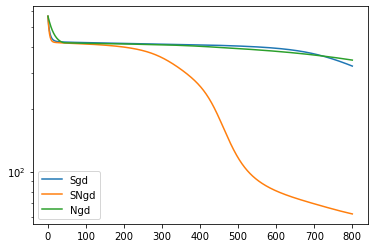

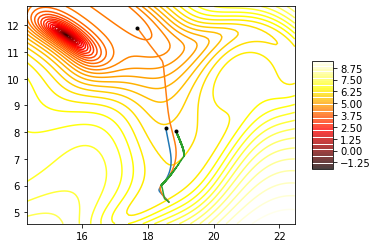

In [13]:
legend = ['Sgd', 'SNgd', 'Ngd']
q_s = [0.0, 0.5, 1.0]
eta_s = np.array([0.0004, 0.002, 0.002])/4
w0 = np.random.randn(2)*9 + np.array([8,8])

l_alls, w_alls, w_range = run_exp(landscape, w0, q_s, eta_s, iter = 800 )

plot_all (l_alls, w_alls, w_range, w0, eta_s, legend )


w0 =  [13.33652039 -4.89600544] , eta =  [0.0001 0.0005 0.0005]


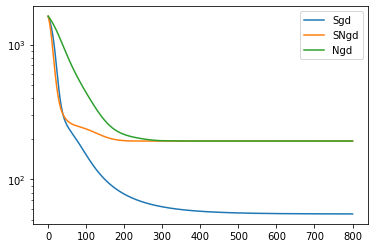

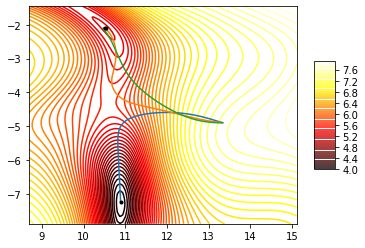

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
iter = 5000
w0 = np.random.randn(2)*9 + np.array([8,8])
w_alls = []; l_alls = []; w_mins = []; w_maxs = []
q_s = [0.0, 0.5, 1.0]
eta_s = [0.0001/2, 0.001/4, 0.005/4]
for q, eta in zip(q_s, eta_s):
#     print(q, eta )
    w = w0.copy()
    w_all = [w.copy()]
    for _ in range(iter):
        loss, err, jac = landscape_loss(w, freq = None, amp = None, py = np)

        w = update_2d(w, err, jac, eta = eta, q=q) 
        w_all.append(w.copy())

    w_all = np.stack(w_all,axis=1)
    
    l_all, _, _ = landscape_loss(w_all)
    w_alls.append(w_all)
    l_alls.append(l_all)
    w_mins.append(w_all.min(axis=1))
    w_maxs.append(w_all.max(axis=1))

w_min, w_max = np.stack(w_mins,axis=1).min(axis=1), np.stack(w_maxs,axis=1).max(axis=1)
diff = (w_max - w_min) /2
cent = (w_max + w_min) / 2 
# min_max[0]-3,min_max[1]+3

# plt.figure(); plt.semilogy(l_alls); plt.show()
plt.figure(); 
for l in l_alls:
    plt.semilogy(l); 
plt.show()


dif = diff.max()*1.25
x0 = np.linspace(cent[0]-dif,cent[0]+dif, 101)
y0 = np.linspace(cent[1]-dif,cent[1]+dif, 101)

plot_3d(landscape_loss, x0,y0, w_all = w_alls) # zlim=[40,200])
# plot_3d(landscape_loss, np.linspace(-10,20, 201), w_all = w_alls) # zlim=[40,200])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/huh/miniconda3/envs/bfs/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …